In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import itertools

In [9]:
root_dir = os.path.dirname(os.getcwd())
export_dir = os.path.join(root_dir, 'export')
df = pd.read_csv(os.path.join(export_dir, 'measurement_files_metadata.csv'))

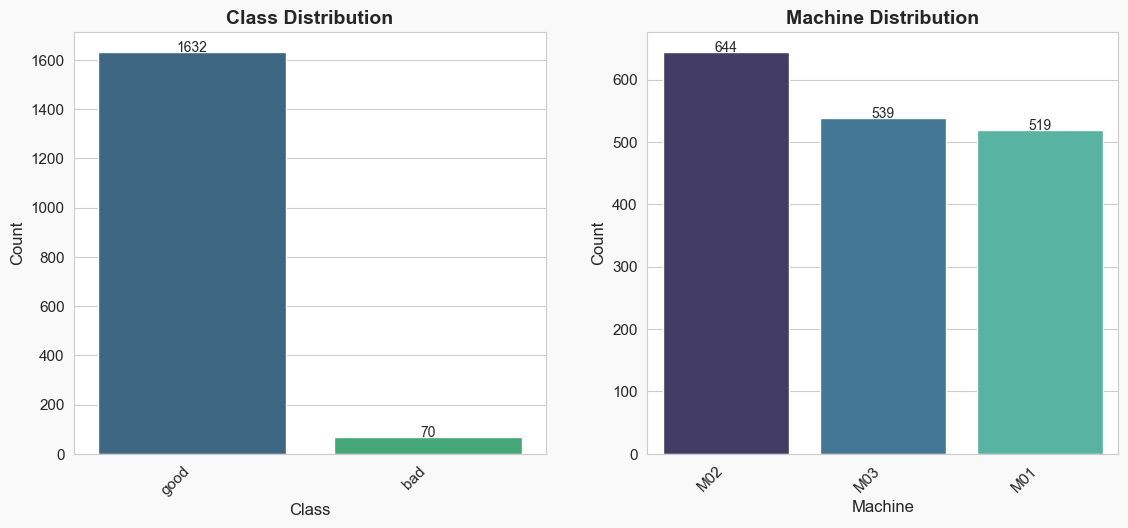

Class Distribution (%):
  good: 95.89%
  bad: 4.11%

Machine Distribution (%):
  M02: 37.84%
  M03: 31.67%
  M01: 30.49%


In [16]:
# Check the class distribution (imbalance)
plt.figure(figsize=(12, 6), facecolor='#f9f9f9')
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11, 'font.family': 'sans-serif'})

# Create a custom color palette
colors = sns.color_palette("viridis", n_colors=len(df['class'].unique()))

# Plot class distribution
plt.subplot(1, 2, 1)
class_counts = df['class'].value_counts().sort_values(ascending=False)
ax1 = sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette=colors, legend=False)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 0.1, str(v), ha='center', fontsize=10)

# Plot machine distribution
plt.subplot(1, 2, 2)
machine_counts = df['machine'].value_counts().sort_values(ascending=False)
machine_colors = sns.color_palette("mako", n_colors=len(df['machine'].unique()))
ax2 = sns.barplot(x=machine_counts.index, y=machine_counts.values, hue=machine_counts.index, palette=machine_colors, legend=False)
plt.title('Machine Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Machine', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for i, v in enumerate(machine_counts.values):
    ax2.text(i, v + 0.1, str(v), ha='center', fontsize=10)

plt.tight_layout(pad=3.0)
plt.savefig('distribution_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Display percentage distribution for better understanding
print("Class Distribution (%):")
class_pct = df['class'].value_counts(normalize=True).mul(100).round(2).sort_values(ascending=False)
for cls, pct in class_pct.items():
    print(f"  {cls}: {pct}%")

print("\nMachine Distribution (%):")
machine_pct = df['machine'].value_counts(normalize=True).mul(100).round(2).sort_values(ascending=False)
for machine, pct in machine_pct.items():
    print(f"  {machine}: {pct}%")
